In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
from pylab import mpl, plt
import plotly.graph_objects as go

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 10
mpl.rcParams['font.family'] = 'serif'

<ipython-input-13-6a6401e262ec>:8: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



**Using AMD stock values as the underlying aset**

<Axes: title={'center': 'AMD Stock Values'}, xlabel='Date'>

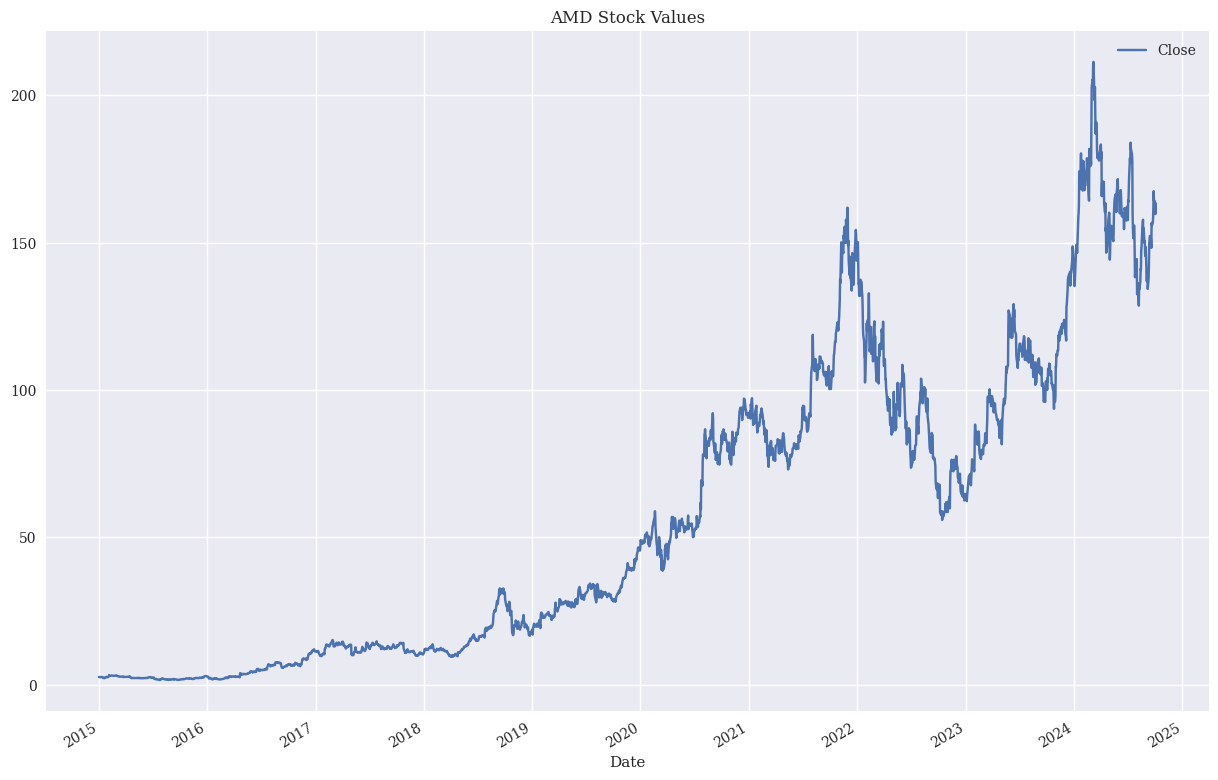

In [ ]:
AMD = yf.Ticker('AMD')
AMD_values = AMD.history(start = '2015-01-01')
AMD_values[['Close']].plot(title = 'AMD Stock Values')

In [ ]:
# Log returns
AMD_values['Returns'] = np.log(AMD_values['Close'] / AMD_values['Close'].shift(1))

In [ ]:
# Compute daily volatility
daily_volatility = np.std(AMD_values['Returns'])

# Compute sigma
sigma = daily_volatility * np.sqrt(252)

# **Binomial Tree model**

In [ ]:
# Option Pricing Model (Binomial Tree)
def binomial_tree(K, S0, r, T, N, sigma, opttype_1 = 'European', opttype_2 = 'C'):
    h = T / N
    u = np.exp(r * h + sigma * np.sqrt(h))
    d = np.exp(r * h - sigma * np.sqrt(h))
    p = (np.exp(r * h) - d) / (u - d)
    disc = np.exp(- r * h)

    # Initialize Asset Values:
    S = S0 * d ** np.arange(N, -1, -1) * u ** np.arange(0, N+1, 1)
    St = [S.copy()]  # Store the stock value at maturity

    # Compute option values at the final node
    price = np.maximum(S - K, np.zeros(N+1)) if opttype_2 == 'C' else np.maximum(K - S, np.zeros(N+1))


    # Store the initial payoffs (at maturity)
    option_values = [price.copy()]

    # Create a list to store delta and B
    delta_values = []
    B_values = []

    # Calculate Option Price at each nodes:
    for i in np.arange(N, 0, -1):
        # Compute delta values
        delta = (price[1:i+1] - price[0:i]) / (S[1:i+1] - S[0:i])
        delta_values.append(delta.copy())

        # Compute B values
        B = disc * (u * price[0:i] - d * price[1:i+1]) / (u - d)
        B_values.append(B.copy())

        # Compute stock values at each nodes
        S = disc * (p * S[1:i+1] + (1-p) * S[0:i])
        St.append(S.copy())  # Store value of stock at each step.

        # Compute option values at each nodes
        if opttype_1 == 'European':
          price = disc * (p * price[1:i+1] + (1-p) * price[0:i])
        else:
          price = np.maximum(S - K, disc * (p * price[1:i+1] + (1-p) * price[0:i])) if opttype_2 == 'C' else np.maximum(K - S, disc * (p * price[1:i+1] + (1-p) * price[0:i]))
        option_values.append(price.copy())

    # Reverse to have values from the initial node down to maturity
    option_values.reverse()
    delta_values.reverse()
    B_values.reverse()
    St.reverse()

    return option_values, delta_values, B_values, St

# **Graph tree**

In [ ]:
def draw_binomial_tree_plotly(call_option_values, delta_values, B_values, St, periods):
    fig = go.Figure()

    # Draw nodes and connect them
    for i in range(periods + 1):
        x = i  # Set x position (horizontal)
        for j in range(i + 1):
            y = j - 0.5 * i  # Set y position (nodes spaced out)
            stock_value = St[i][j]
            delta_value = delta_values[i][j] if i < len(delta_values) else None
            B_value = B_values[i][j] if i < len(B_values) else None

            # Add Call Option value to node
            call_value = call_option_values[i][j]

            # Create node label with Option value, Delta, B values, and Call Option price
            node_text = (f'S: {stock_value:.2f}<br>'
                         f'Δ: {delta_value:.2f}<br>'
                         f'B: {B_value:.2f}<br>'
                         f'Price: {call_value:.2f}' if delta_value is not None and B_value is not None else f'S: {stock_value:.2f}<br>Price: {call_value:.2f}')

            fig.add_trace(go.Scatter(x=[x], y=[y], text=node_text, mode='markers+text',
                                     textposition='top center', marker=dict(size=14),
                                     textfont=dict(size=12, family="Arial")))

            # Draw lines connecting the nodes
            if i < periods:
                fig.add_trace(go.Scatter(x=[x, x + 1], y=[y, y - 0.5], mode='lines', line=dict(color='black', width=2)))
                fig.add_trace(go.Scatter(x=[x, x + 1], y=[y, y + 0.5], mode='lines', line=dict(color='black', width=2)))

    # Customize the layout of the plot (horizontal)
    fig.update_layout(showlegend=False,
                      title='Binomial Tree model',
                      title_x=0.5,  # Center the title
                      font=dict(size=14),  # Increase font size
                      xaxis=dict(visible=False),
                      yaxis=dict(visible=False),
                      plot_bgcolor='white',
                      width=1500, height=800)  # Increase plot size

    fig.show()


In [ ]:
K = 150  # Strike price
S0 = AMD_values['Close'].iloc[-1]  # Initial stock price
r = 3.73 / 100  # Risk-free rate
T = 1  # Time to maturity
N = 5  # Number of time steps
sigma
opttype_1 = 'European'
opttype_2 = 'C'
option_values, delta_values, B_values, St = binomial_tree(K, S0, r, T, N, sigma, opttype_1, opttype_2)

# Plot
draw_binomial_tree_plotly(option_values, delta_values, B_values, St, N)

# **Black - Scholes model**

**BS option pricing model**

In [ ]:
# Black Scholes Option Pricing function
def BlackScholes(K, S0, r, sigma, T, div, opttype = 'C'):
  d1 = (np.log(S0 / K) + (r + sigma**2 / 2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))

  # Option Pricing
  price = (S0 * norm.cdf(d1, 0, 1) - K * np.exp(-r*T) * norm.cdf(d2, 0, 1)) if opttype == 'C' else (K * np.exp(-r*T) * norm.cdf(-d2, 0, 1) - S0 * norm.cdf(-d1, 0 ,1))

  # Greeks calculation

  # Delta
  if opttype == 'C':
    delta = np.exp(-div * T) *norm.cdf(d1)
  else:
    delta = -np.exp(-div * T) *norm.cdf(-d1)

  # Gamma
  gamma = np.exp(-div * T) * norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

  # Theta
  if opttype == 'call':
    theta = (-S0 * div * np.exp(-div * T) * norm.cdf(d1) * sigma - r * K * np.exp(-r * T) * norm.cdf(d2) - \
               r * K * np.exp(-r * T) * norm.pdf(d2) * sigma / 2 * np.sqrt(T)) * (1/365)
  else:
    theta = (-S0 * div * np.exp(-div * T) * norm.cdf(-d1) * sigma + r * K * np.exp(-r * T) * norm.cdf(-d2) - \
               r * K * np.exp(-r * T) * norm.pdf(d2) * sigma / 2 * np.sqrt(T)) * (1/365)

  # Vega
  vega = S0 * np.exp(-div * T) * norm.pdf(d1) * np.sqrt(T)

  # Rho
  if opttype == 'call':
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)
  else:
    rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

  # Psi
  if opttype == 'call':
    psi = -S0 * T * np.exp(-div * T) * norm.cdf(d1)
  else:
    psi =  S0 * T * np.exp(-div * T) * norm.cdf(-d1)

  return {
        'Option Price': price,
        'Delta': delta,
        'Gamma': gamma,
        'Theta': theta,
        'Vega': vega,
        'Rho': rho,
        'Psi': psi
    }

In [ ]:
K = 150  # Strike price
S0 = AMD_values['Close'].iloc[-1]  # Initial stock price
r = 3.73 / 100  # Risk-free rate
T = 1  # Time to maturity
div = 0
sigma
opttype = 'C'
BlackScholes(K, S0, r, sigma, T, div, opttype = 'C')

{'Option Price': 45.31209098951939,
 'Delta': 0.6918679773872347,
 'Gamma': 0.003711819010704536,
 'Theta': 0.006145807352899135,
 'Vega': 57.469675839739224,
 'Rho': -76.81735435644505,
 'Psi': 50.327203817549545}

In [ ]:
# Define Constants
K = 150  # Strike price
S0 = AMD_values['Close'].iloc[-1]  # Initial stock price
r = 3.73 / 100  # Risk-free rate
T = 1  # Time to maturity
div = 0
sigma

# Value lists
N_values = np.arange(1, 1001, 10) # N from 1 to 1000
binomial_prices = []
black_scholes_prices = []
price_differences = []

# Compute option price for each N
for N in N_values:
    # Binomial Tree model
    option_values_binomial, _, _, _ = binomial_tree(K, S0, r, T, N, sigma, opttype_1='European', opttype_2='C')
    price_binomial = option_values_binomial[0]

    # Black-Scholes
    option_value_BS = BlackScholes(K, S0, r, sigma, T, div, opttype_1='European', opttype_2='C')

    # Save the prices
    binomial_prices.append(price_binomial)
    black_scholes_prices.append(option_value_BS)

    # Tính sự chênh lệch giá
    price_differences.append(abs(price_binomial - option_value_BS))

# **Binomial model VS. Black - Scholes model**

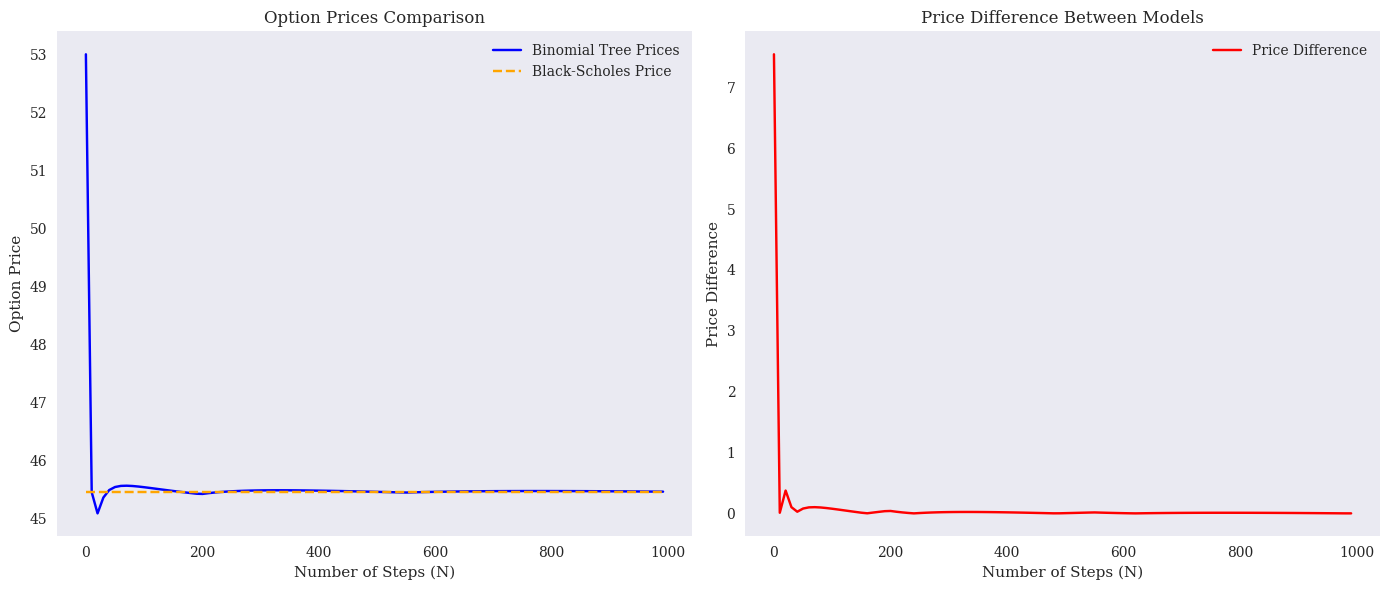

In [ ]:
# Plot
plt.figure(figsize=(14, 6))

# Option Price graph
plt.subplot(1, 2, 1)
plt.plot(N_values, binomial_prices, label='Binomial Tree Prices', color='blue')
plt.plot(N_values, black_scholes_prices, label='Black-Scholes Price', color='orange', linestyle='--')
plt.title('Option Prices Comparison')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.legend()
plt.grid()

# Difference in price between 2 models
plt.subplot(1, 2, 2)
plt.plot(N_values, price_differences, label='Price Difference', color='red')
plt.title('Price Difference Between Models')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Price Difference')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

These graphs show that as $N \to \infty $, the binomial option price approaches the BS option prices. Or we can write it informally as:
$$
\lim_{N \to \infty} C_{Binomial} = C_{BS}.
$$
